In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import os
from ucimlrepo import fetch_ucirepo

# Data import and overview

In [14]:
data_dir = "../data/raw"
name = "credit_default.csv"


In [12]:
def download_data(file_name, id=350):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    file_path = os.path.join(data_dir, name)
    if not os.path.isfile(file_path):
        dataset = fetch_ucirepo(id = id)
        df = dataset.data.original
        with open(file_path, 'w') as f:
            f.write(df.to_csv(index=False))
    else:
        df = pd.read_csv(file_path)
    
    return df

In [13]:
data = download_data(name, id=350)
data.head()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [15]:
data["Y"].value_counts(normalize=True)

Y
0    0.7788
1    0.2212
Name: proportion, dtype: float64

```
Default percentage = 22.12%
Non Default percentage = 77.88%
```

In [16]:
data.shape

(30000, 25)

In [19]:
data.isna().sum().sort_values(ascending=False)

ID     0
X13    0
X23    0
X22    0
X21    0
X20    0
X19    0
X18    0
X17    0
X16    0
X15    0
X14    0
X12    0
X1     0
X11    0
X10    0
X9     0
X8     0
X7     0
X6     0
X5     0
X4     0
X3     0
X2     0
Y      0
dtype: int64

In [21]:
data.duplicated().sum()

np.int64(0)

# EDA

## Target imbalance visualisation

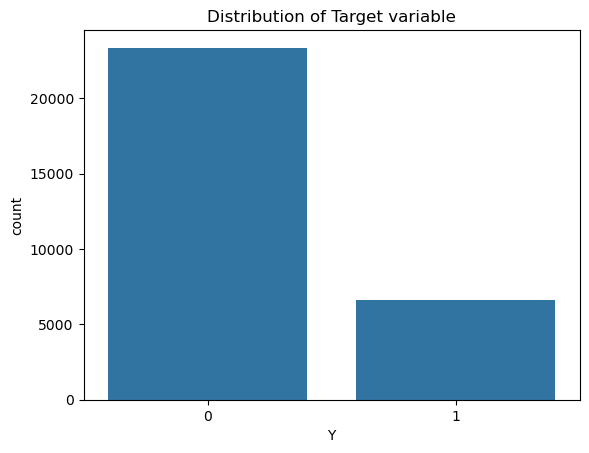

In [24]:
sns.countplot(x = "Y", data=data)
plt.title("Distribution of Target variable")
plt.show()

From the plot above, its very clear that the target variable is imbalanced with majority of the customers not defaulting on their loans. Any modelling technique we employ should take this into consideration. 

The accuracy metric will not be a good measure in this instance as any dummy classifier that predicts all customers as non defaulters will have at least 77% accuracy. 

In this business case, we are more interested in identifying defaulters correctly even if we end up misclassifying some non defaulters. We are therefore more interested in minimizing false negatives (Type II error)

- Default rate: ~22.1%, indicating severe class imbalance.
- No missing values detected.
- Features include a mix of:
  - Ordinal variables 
  - Nominal categorical variables encoded numerically
  - Continuous numerical variables
- All features are currently stored as numeric (int/float).

# Data Schema

Target
- Y : binary (0, 1)

Feature Types
- Continuous:
  - X1 (Credit limit)
  - X12 - X17 (Amount of bill statements)
  - X18 - X23 (Amount of previous payment)
  - X5 (Age in years)
- Ordinal:
  - X3 (Education level)[1 = graduate school; 2 = university; 3 = high school; 4 = others]
  - X6 - X11 (History of past payments) [-1 to 9]
  - X4 (Marital status)[1 = married; 2 = single; 3 = others]
- Categorical (encoded as integers):
  - X2 (Gender)[1 = male; 2 = female]


In [46]:
pay_cols = [ f"X{i}" for i in range(6,12) ]
education = ["X3"]
marital_status = ["X4"]

In [ ]:
target = "Y"

ordinal_features = education + marital_status + pay_cols

categorical_features = [
    "X2"
]

continuous_features = [ "X1" ] + [
    f"X{i}" for i in range(12,24)
] + [ "X5" ]


# Data Validation

The dataset must satisfy the following constraints:

### Schema
- All expected columns must be present
- No unexpected columns are allowed

### Target
- `Y` must be binary {0, 1}
- No missing values allowed

### Feature Constraints
- Ordinal features must lie within known bounds
- Categorical features must take known discrete values
- Continuous features must be numeric and finite

Any violation should raise an exception and stop execution.

In [31]:
def validate_data(
    df: pd.DataFrame,
    target: str,
    ordinal_features: list,
    categorical_features: list,
    continuous_features: list
):
    # Schema checks 
    expected_columns = (
        ordinal_features
        + categorical_features
        + continuous_features
        + [target]
        + ["ID"]
    )

    missing_cols = set(expected_columns) - set(df.columns)
    extra_cols = set(df.columns) - set(expected_columns)

    if missing_cols:
        raise ValueError(f"Missing columns: {missing_cols}")

    if extra_cols:
        raise ValueError(f"Unexpected columns: {extra_cols}")

    # Target checks 
    if not set(df[target].unique()).issubset({0, 1}):
        raise ValueError("Target variable must be binary {0,1}")

    if df[target].isna().any():
        raise ValueError("Target contains missing values")

    # Ordinal checks 
    for col in ordinal_features:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise TypeError(f"Ordinal column {col} must be numeric")

    # Categorical checks 
    for col in categorical_features:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise TypeError(f"Categorical column {col} must be numeric-encoded")

    # ---- Continuous checks ----
    for col in continuous_features:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise TypeError(f"Continuous column {col} must be numeric")

        if not np.isfinite(df[col]).all():
            raise ValueError(f"Continuous column {col} contains non-finite values")

    print("✅ Data validation passed.")

In [38]:
validate_data(
    df = data,
    target = target,
    ordinal_features = ordinal_features,
    categorical_features=categorical_features,
    continuous_features=continuous_features
)

✅ Data validation passed.


# Feature engineering and encodings 

In [40]:
print("Unique education levels: ",data["X3"].unique())
print("Unique marital status: ",data["X4"].unique())

Unique education levels:  [2 1 3 5 4 6 0]
Unique marital status:  [1 2 3 0]


In [74]:
pay_order = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7,8,9]
education_order = [0,1,2,3,4,5,6]
marital_order = [0,1,2,3]


In [52]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["ID", "Y"])
y = data["Y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
    )

In [45]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [78]:
gender_categories = sorted(data["X2"].unique().tolist())
gender_categories

[1, 2]

In [79]:
pay_enc = OrdinalEncoder(
    categories=[pay_order]*len(pay_cols),
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

education_encoder = OrdinalEncoder(
    categories=[education_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

marital_enc = OrdinalEncoder(
    categories=[marital_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

preprocessor = make_column_transformer(
    (StandardScaler(), continuous_features),
    (OneHotEncoder(categories=[gender_categories],drop='if_binary',sparse_output=False, handle_unknown='ignore'), categorical_features),
    (pay_enc, pay_cols),
    (education_encoder, education),
    (marital_enc, marital_status),
    remainder="passthrough"
)

# Baseline Model

We define a baseline model to act as a benchmark to compare our model against

In [80]:
from sklearn.dummy import DummyClassifier

In [81]:
dummy_pipe = make_pipeline(
    preprocessor,
    DummyClassifier(strategy='most_frequent')
)

In [82]:
dummy_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('dummyclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('standardscaler', ...), ('onehotencoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0

In [84]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

y_test_pred = dummy_pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

accuracy, precision, recall, roc_auc

(0.7787777777777778, 0.0, 0.0, 0.5)

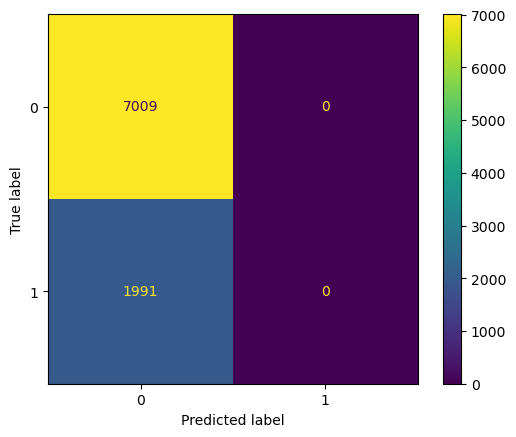

In [85]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

The dummy classifier achieves high accuracy by predicting only the majority class.
However, it completely fails to identify defaulting customers, resulting in zero recall.
This establishes a minimum performance benchmark that any real model must exceed.